In [2]:
import pandas as pd
import os
import opendatasets as od
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2 as cv
import random as rnd
from functions import *

### Getting Dataset

In [3]:
x = get_x_data()

In [4]:
y = get_target()

In [5]:
y = pd.get_dummies(pd.DataFrame(y))

In [6]:
y = y.replace({True: 1, False: 0})

In [7]:
y = np.asarray(y)

### Data Augmentation Before Spltting

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Dropout, Rescaling
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet

2024-04-29 12:51:46.406828: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 12:51:46.859166: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-29 12:51:46.900099: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clay/.local/lib/python3.8/site-packages/cv2/../../lib64:
2024-04-29 12:51:46.

In [9]:
from tensorflow.keras.layers import RandomZoom, RandomContrast, RandomRotation

In [10]:
data_augmentation_layers = [
    RandomZoom((0.1, 0.5)),
    RandomRotation(0.5),
    RandomContrast(0.2)
]


def data_augmentation(imgs):
    for layer in data_augmentation_layers:
        imgs = layer(imgs)
    return imgs

In [11]:
augmented_x = data_augmentation(x)

2024-04-29 12:51:50.877776: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/clay/.local/lib/python3.8/site-packages/cv2/../../lib64:
2024-04-29 12:51:50.880431: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-29 12:51:50.880472: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-AB0NGOS5): /proc/driver/nvidia/version does not exist
2024-04-29 12:51:50.886978: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with

### Visualizing Augmentation

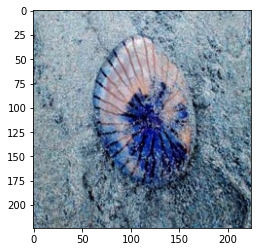

In [12]:
plt.imshow(x[0])

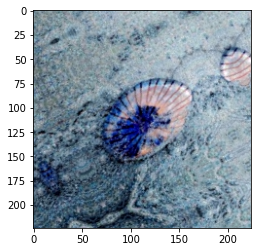

In [13]:
plt.imshow(np.array(augmented_x[0]).astype("uint8"))

##### Splitting Data

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
x_train, x_test, y_train, y_test = train_test_split(np.asarray(augmented_x), y, test_size = 0.3)

### Testing Augmentation with ResNetModel with Dropout Rate 0.3

In [16]:
def ResNetAugmentation(input_shape):
    base = ResNet50(input_shape = input_shape, weights = 'imagenet',
                    include_top = False, pooling = 'avg')
    base.trainable = False
    
    inputs = Input(input_shape)
    x = resnet.preprocess_input(inputs)
    x = Dropout(0.3)(x)
    x = base(x)
    
    outputs = Dense(5, activation = 'softmax')(x)
    
    return Model(inputs, outputs, name = 'ResNetAugmentation')

In [17]:
aug_model = ResNetAugmentation(input_shape = (224, 224, 3))
aug_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [18]:
aug_history = aug_model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 10)

Epoch 1/10
11/11 [==============================] - 23s 2s/step - loss: 1.6464 - accuracy: 0.3457 - val_loss: 1.3266 - val_accuracy: 0.4400
Epoch 2/10
11/11 [==============================] - 19s 2s/step - loss: 0.9946 - accuracy: 0.5829 - val_loss: 1.2137 - val_accuracy: 0.4933
Epoch 3/10
11/11 [==============================] - 19s 2s/step - loss: 0.7790 - accuracy: 0.6914 - val_loss: 1.1265 - val_accuracy: 0.5533
Epoch 4/10
11/11 [==============================] - 20s 2s/step - loss: 0.6479 - accuracy: 0.7686 - val_loss: 1.0361 - val_accuracy: 0.6000
Epoch 5/10
11/11 [==============================] - 20s 2s/step - loss: 0.5360 - accuracy: 0.8229 - val_loss: 1.0216 - val_accuracy: 0.6333
Epoch 6/10
11/11 [==============================] - 20s 2s/step - loss: 0.4724 - accuracy: 0.8543 - val_loss: 0.9308 - val_accuracy: 0.6667
Epoch 7/10
11/11 [==============================] - 20s 2s/step - loss: 0.4238 - accuracy: 0.8571 - val_loss: 0.9862 - val_accuracy: 0.6200
Epoch 8/10
11/11 [==

Augmentation had a negative effect for both training and validation accuracy, but a much larger one for training accuracy.

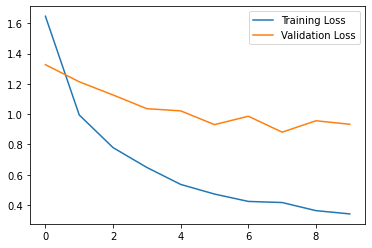

In [19]:
plt.plot(range(len(aug_history.history['loss'])), aug_history.history['loss'], label = 'Training Loss')
plt.plot(range(len(aug_history.history['val_loss'])), aug_history.history['val_loss'], label = 'Validation Loss')
plt.legend()

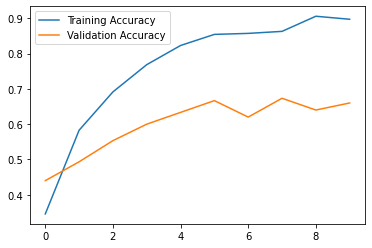

In [20]:
plt.plot(range(len(aug_history.history['accuracy'])), aug_history.history['accuracy'], label = 'Training Accuracy')
plt.plot(range(len(aug_history.history['val_accuracy'])), aug_history.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()

In [23]:
from tensorflow.keras.metrics import AUC

In [24]:
def get_aug_model():
    aug_model = ResNetAugmentation(input_shape = (224, 224, 3))
    aug_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = [AUC(multi_label = True, num_labels = 5)])
    return aug_model

aug_model = get_aug_model()

aug_model.fit(x_test, y_test, epochs = 10)

aug_model.save('my_aug_model.keras')

Epoch 1/10
5/5 [==============================] - 7s 1s/step - loss: 2.0123 - auc: 0.5335
Epoch 2/10
5/5 [==============================] - 5s 1s/step - loss: 1.3930 - auc: 0.7422
Epoch 3/10
5/5 [==============================] - 5s 1s/step - loss: 1.0093 - auc: 0.8848
Epoch 4/10
5/5 [==============================] - 6s 1s/step - loss: 0.8172 - auc: 0.9246
Epoch 5/10
5/5 [==============================] - 7s 1s/step - loss: 0.6297 - auc: 0.9624
Epoch 6/10
5/5 [==============================] - 6s 1s/step - loss: 0.5426 - auc: 0.9758
Epoch 7/10
5/5 [==============================] - 6s 1s/step - loss: 0.4048 - auc: 0.9892
Epoch 8/10
5/5 [==============================] - 6s 1s/step - loss: 0.3862 - auc: 0.9922
Epoch 9/10
5/5 [==============================] - 6s 1s/step - loss: 0.3293 - auc: 0.9941
Epoch 10/10
5/5 [==============================] - 6s 1s/step - loss: 0.3090 - auc: 0.9950
